In [86]:
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
import modules.data_selector_helper as data_help
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn import model_selection 
from sklearn.model_selection import cross_val_score
import math
import xgboost
import modules.file_helper as file_help

### 0. Initialization

In [87]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
global_data = pd.read_csv(os.path.join(file_help.DATA_OUT_FOLDER, 'Maison' + file_help.FILE_NAME_OUT_EXT), encoding='utf-8', sep=';', decimal='.')


### 1. Isolate data for the simulation of prediction

In [89]:
working_data = data_help.get_sells_from_insee_code(63113, 'Maison', 50)
print('number of data selected : ' + str(len(working_data)))


number of data selected : 4897


### 2. Last cleanup : Isolation Forest on selected data

In [90]:
#Use Isolation forest model to finalize cleanup of dataset
df = working_data[['Surface reelle bati','Nombre pieces principales','Surface terrain', 'Valeur fonciere', 'distance']]

iForest = IsolationForest(n_estimators=100,  contamination=0.1 , random_state=42, max_samples=200)
iForest.fit(df)

df['anomaly'] = iForest.predict(df)
print('number of anomalies found : %s' % len(df[df['anomaly'] == -1]))

working_data.drop(df.loc[df['anomaly'] == -1].index, inplace=True)

print('new number of data : %s' % len(working_data))


number of anomalies found : 490
new number of data : 4407


### 3. Correlations between features and target

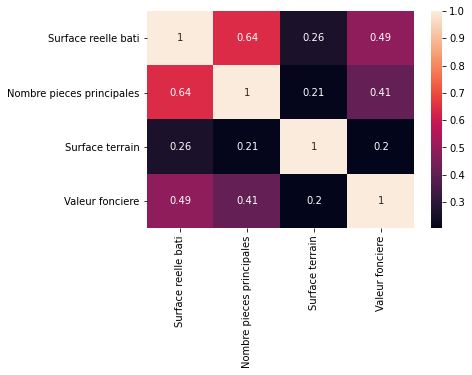

In [91]:

# New correlation matrix
matrix = working_data[['Surface reelle bati','Nombre pieces principales','Surface terrain','Valeur fonciere']]
mat_corr = matrix.corr().round(5)
sns.heatmap(data=mat_corr, annot=True)
del(matrix)


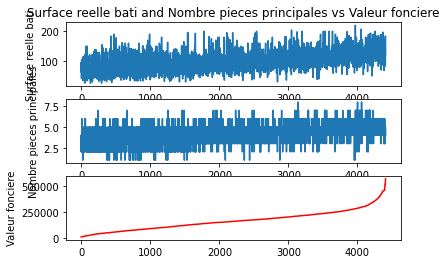

In [92]:

y = working_data.loc[:,['Surface reelle bati','Nombre pieces principales', target]].sort_values(target, ascending=True).values
x = np.arange(y.shape[0])

plt.subplot(3,1,1)
plt.plot(x,y[:,0])
plt.title('Surface reelle bati and Nombre pieces principales vs Valeur fonciere')
plt.ylabel('Surface reelle bati')

plt.subplot(3,1,2)
plt.plot(x,y[:,1])
plt.ylabel('Nombre pieces principales')

plt.subplot(3,1,3)
plt.plot(x,y[:,2],'r')
plt.ylabel('Valeur fonciere')


plt.show()
del(x)



### 4. Test Scikit-Learn Linear regression

In [93]:
regr = LinearRegression()

X =  working_data[['Surface reelle bati','Nombre pieces principales','Surface terrain']].values
y = working_data['Valeur fonciere'].values
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y ,test_size=0.3)


In [94]:
regr.fit(X_train, y_train)
score = regr.score(X_test,y_test)
print("Training score xith skLearn: ", score)


Training score xith skLearn:  0.26863257160413057


In [95]:
scores = cross_val_score(regr, X_train, y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())

Mean cross-validation score: 0.25


In [96]:
# Calculate the Root Mean Squared Error
print("RMSE: L'erreur quadratique moyenne est de %.2f€"
      % math.sqrt(np.mean((regr.predict(X_test) - y_test) ** 2)))


RMSE: L'erreur quadratique moyenne est de 78400.76€


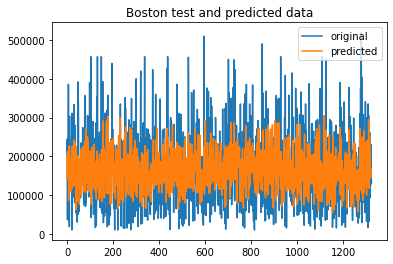

In [97]:
ypred = regr.predict(X_test)
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, ypred, label="predicted")

plt.title("Boston test and predicted data")

plt.legend()
plt.show()

### 5. Test XgBoost Linear regression

In [98]:
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,                    colsample_bytree=1, max_depth=7)

xgb.fit(X_train,y_train)

score = xgb.score(X_train, y_train)  
print("Training score xith Xgboost: ", score)


Training score xith Xgboost:  0.7111460213357141


In [99]:
scores = cross_val_score(xgb, X_train, y_train,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())


Mean cross-validation score: 0.34


In [100]:
# Calculate the Root Mean Squared Error
print("RMSE: L'erreur quadratique moyenne est de %.2f€"
      % math.sqrt(np.mean((xgb.predict(X_test) - y_test) ** 2)))

RMSE: L'erreur quadratique moyenne est de 73998.75€


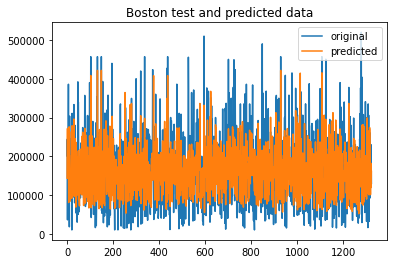

In [101]:
ypred = xgb.predict(X_test)
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, ypred, label="predicted")

plt.title("Boston test and predicted data")

plt.legend()
plt.show()

# Conclusion : use XgBoost!